# San Francisco has a larger proportion of drink and drug related crimes than Seattle

![title](final_figure.png)

The above figure shows the fraction of all crimes in the cities of San Francisco (blue) and Seattle (red) that are due to drink (dotted lines) and drugs (solid lines) as a function of the time of day.

From this figure it is clear that San Francisco has a higher fraction of crimes due to both drink and drugs. The relative rates of drug crimes are also seen to peak around mid afternoon. Drink related crimes show a flatter trend and are perhaps peaked late at night.

The data shown above are for the full incident datasets for each city available via their respective data portal sites. The reader should note that for performance reasons the code shown below will reproduce these results using the limited summer 2014 datasets.

## Code and supporting figures

The following code will document how the above figure was produced. Along the way we will also see a select number of interesting supporting figures.

The first thing we do is to import [pandas](http://pandas.pydata.org/) which we will use to read and handle the data.

In [1]:
import pandas as pd
sf_data = pd.read_csv("sanfrancisco_incidents_summer_2014.csv")

This has loaded the San Francisco Summer 2014 crime incidents into a dataframe object. As we are interested in plotting the data as a function of the time of day, reguardless of the date, the next step is to bin the data into time ranges. There are a few ways to do this. I've followed the solution discussed [here](http://wrobstory.github.io/2013/04/real-world-pandas-1.html) which uses numpy digitize to handle the binning. To implement this solution we first define the binning function.

In [2]:
import numpy as np
def map_bin(x, bins):
    kwargs = {}
    if x == max(bins):
        kwargs['right'] = True
    bin = bins[np.digitize([x], bins, **kwargs)[0]]
    bin_lower = bins[np.digitize([x], bins, **kwargs)[0]-1]
    return '[{0}-{1}]'.format(bin_lower, bin)

The next stage is to define the time binning. These are the edges of the bins, so to have 24 bins we need 25 edges.

In [3]:
time_bins = np.arange(0, 25, 1)

Next we take the time column from our input data and massage it into the format we need. In the case of the SF data a time column is provided that is a string in the format HH:MM. Let's use some ugly list comprehension to pull this out as a floating point number.

In [4]:
sf_time_float = [float(a.split(":")[0]) + (float(a.split(":")[1]) / 60. ) for a in sf_data["Time"].values]

Next we use this to insert a new column into our dataframe which contains the time bin as computed by the mapper function defined above.

In [5]:
sf_data['TimeBinned'] = [map_bin(x, time_bins) for x in sf_time_float]

Inspecting the head of the table we see that our new column has been added (you may have to scroll to the right to see it).

In [6]:
sf_data.head(2)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,TimeBinned
0,140734311,ARSON,ARSON OF A VEHICLE,Sunday,08/31/2014,23:50,BAYVIEW,NONE,LOOMIS ST / INDUSTRIAL ST,-122.405647,37.738322,"(37.7383221869053, -122.405646994567)",14073431126031,[23-24]
1,140736317,NON-CRIMINAL,LOST PROPERTY,Sunday,08/31/2014,23:45,MISSION,NONE,400 Block of CASTRO ST,-122.435012,37.761768,"(37.7617677182954, -122.435012093789)",14073631771000,[23-24]


Now we're ready to start visualising this data. The first thing we'll look at is the overall number of crimes in each hourly bin. We do this using the groupby feature of the dataframe to combine everything SQL style within each time bin.

In [7]:
sf_grouped_data = sf_data.groupby('TimeBinned')

We then use the count method to add up all of the crimes within each time bin

In [8]:
sf_counted_data = sf_grouped_data.count()
sf_counted_data.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
TimeBinned,,,,,,,,,,,,,
[0-1],1381,1381,1381,1381,1381,1381,1381,1381,1381,1381,1381,1381,1381
[1-2],821,821,821,821,821,821,821,821,821,821,821,821,821
[10-11],1206,1206,1206,1206,1206,1206,1206,1206,1206,1206,1206,1206,1206
[11-12],1298,1298,1298,1298,1298,1298,1298,1298,1298,1298,1298,1298,1298
[12-13],1779,1779,1779,1779,1779,1779,1779,1779,1779,1779,1779,1779,1779


Note that now we have a large amount of redundant information as the count of every column is equal to the total number of incidents in each time bin. Further note that the time bins are string ordered and not ordered in time as we will later need. The next step is to restrict ourselves to one column (we'll pick the X column for no good reason) and to reindex the dataframe such that it is in the correct order. Firstly picking only one column:

In [9]:
sf_counted_data = sf_counted_data["X"]
sf_counted_data.head(5)

TimeBinned
[0-1]      1381
[1-2]       821
[10-11]    1206
[11-12]    1298
[12-13]    1779
Name: X, dtype: int64

And then re-indexing (sorting) the data.

In [10]:
step = time_bins[1]-time_bins[0]
new_index = ['[{0}-{1}]'.format(x, x+step) for x in time_bins]
new_index.pop(-1)
sf_counted_data = sf_counted_data.reindex(new_index)
sf_counted_data.head()

TimeBinned
[0-1]    1381
[1-2]     821
[2-3]     654
[3-4]     413
[4-5]     245
Name: X, dtype: int64

The final step before we're ready to visualise this is to turn it into an array so that MatPlotLib can handle it, and along the way we'll replace any NaN instances with zeros.

In [11]:
sf_denom = np.nan_to_num(sf_counted_data.values)

Let's get plotting! To do this we import [matplotlib](http://matplotlib.org/) and set the inline option so that our plot will show up in this notebook.

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

Next we plot our data as a histogram where each bin centre is joined by a line. To do this we define our bin centres and then make the figure.

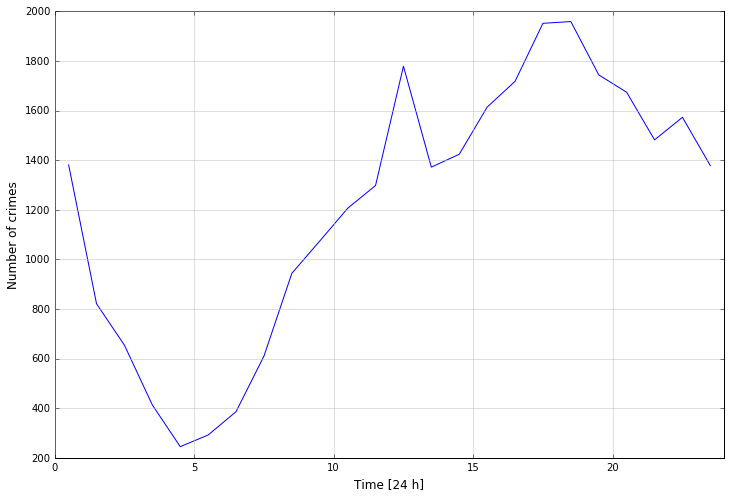

In [13]:
time_bin_centres = [a+0.5 for a in time_bins[:-1]]
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(time_bin_centres, sf_denom, label="San Francisco")
ax.set_xlim([0,24])
ax.set_xlabel("Time [24 h]",fontsize=12)
ax.set_ylabel("Number of crimes",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')
plt.show()

Lovely. Next let us include the same thing for Seattle then we can get to explaining what's going on. This code will be slightly more compact than the above. 

A couple of points to note:
 * Firstly: we're ignoring a warning on import of the data - I think this is fine. 
 * Secondly: the incident time for Seattle is in a very different format, so requires different massaging to get into the format we need.
 * Thirdly: there is no X field in this dataset so we arbitrarily pick Latitude instead.

In [15]:
seattle_data = pd.read_csv("seattle_incidents_summer_2014.csv") 

/Users/mt354/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
seattle_time_float = [float(a.hour) + (float(a.minute) / 60.) for a in pd.to_datetime(seattle_data['Occurred Date or Date Range Start'].values)]
seattle_data['TimeBinned'] = [map_bin(x, time_bins) for x in seattle_time_float]
seattle_denom = np.nan_to_num(seattle_data.groupby('TimeBinned').count().reindex(new_index)["Latitude"].values)

Great. Now let's plot this on top of our existing San Francisco (SF) data.

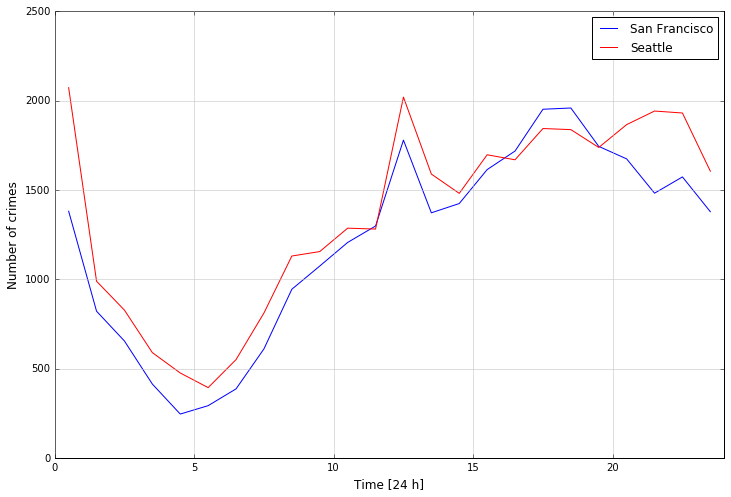

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(time_bin_centres, sf_denom, label="San Francisco")
plt.plot(time_bin_centres, seattle_denom, label="Seattle", c="r")
ax.set_xlim([0,24])
ax.set_xlabel("Time [24 h]",fontsize=12)
ax.set_ylabel("Number of crimes",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')
plt.legend()
plt.show()

This figure shows the total number of crimes in each of the two cities as a function of time of day. There are a few interesting features here:

 * Both cities have a similar number of incidents reported during this time frame. Seattle with marginally more than SF.
 * There is a clear sinusoidal modulation in both datasets with the time of day, with a peak in the evening and a dip in the early morning.
 * There are a couple of spikes in the data that a further analysis could delve into. These are seen at around midday and midnight. A quick study of the midday peak reveals that a number of crime types show a peak at midday - may be people report these at lunch time. A look at the midnight peak reveals a number of incidents that one wouldn't naively expect to happen at midnight. I suspect midnight might be a default entry for when the time isn't known. Further analysis of these is beyond the scope of this analysis.

The next thing to do is to break down these crimes into those caused by drink and those caused by drugs. This is acheived by filtering our dataframe.

For SF it is trivial to filter crimes using the `Category` column and matching this to the values of `DRUG/NARCOTIC` for drugs and `DRUNKENNESS` for drink.

For Seattle the analysis is a bit more nuanced. Here we filter on the `Summary Offense Code` column values identified as that related to drink and drug offenses.

The below code will extract the information we need and also compute the ratio of it to the total number of crimes. The results are stored into dictionaries for later analysis.

In [18]:
# Loop over categories
categories = []
# format: label, sf category, seattle summary offense code
categories.append( ("Drugs", "DRUG/NARCOTIC", "3500") )
categories.append( ("Drink", "DRUNKENNESS",   "4100") )
# A dictionary to save the numerators in for later vis
numerators = {}
# The same for the ratios
ratios = {}
# Loop over categories
for category in categories:
    this_sf_data = sf_data[  sf_data["Category"]   == category[1]]
    sf_numerator = np.nan_to_num(this_sf_data.groupby('TimeBinned').count().reindex(new_index)["X"].values)
    numerators["SF_%s"%category[0]] = sf_numerator

    this_seattle_data = seattle_data[  seattle_data["Summary Offense Code"]   == category[2]]
    seattle_numerator = np.nan_to_num(this_seattle_data.groupby('TimeBinned').count().reindex(new_index)["Latitude"].values)
    numerators["Seattle_%s"%category[0]] = seattle_numerator
    
    sf_ratio = []
    seattle_ratio = []
    for i,d in enumerate(sf_denom):
        sf_ratio.append(100.* (float(sf_numerator[i])/ d) )
        seattle_ratio.append(100.* (float(seattle_numerator[i])/seattle_denom[i]))
        
    ratios["SF_%s"%category[0]]      = sf_ratio
    ratios["Seattle_%s"%category[0]] = seattle_ratio

Now we have our data, let's first plot the total incidence rate of each crime type in both cities.

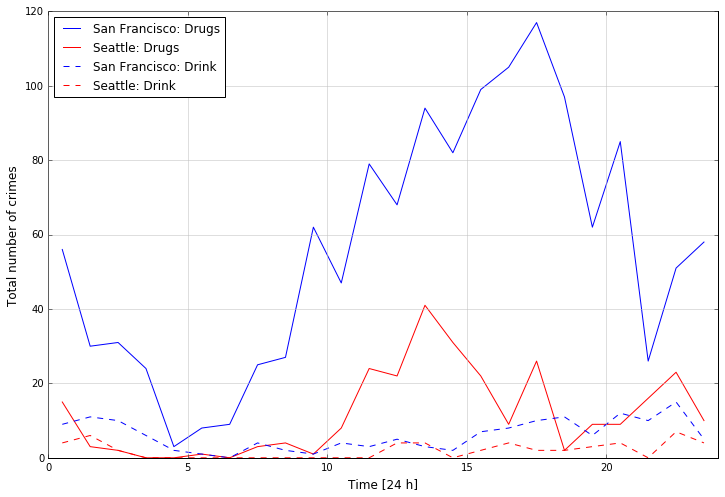

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(time_bin_centres, numerators["SF_Drugs"],      label="San Francisco: Drugs", c="b", linestyle="-")
plt.plot(time_bin_centres, numerators["Seattle_Drugs"], label="Seattle: Drugs",       c="r", linestyle="-")
plt.plot(time_bin_centres, numerators["SF_Drink"],      label="San Francisco: Drink", c="b", linestyle="--")
plt.plot(time_bin_centres, numerators["Seattle_Drink"], label="Seattle: Drink",       c="r", linestyle="--")
ax.set_xlim([0,24])
ax.set_xlabel("Time [24 h]",fontsize=12)
ax.set_ylabel("Total number of crimes",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')
plt.legend(loc=2)
plt.show()

It is very clear from this plot that San Francisco has consiberable more drug related crimes than Seattle and that these follow a similar trend as a function of time as the overall crime rate was observed to do above.

Similarly San Francisco has a higher incidence of drink related crime, but this represents a much smaller fraction of the total crime rate. Interestingly drink related crimes peak later in the evening than drug related ones.

Next let's look at this as a fraction of all crimes committed.

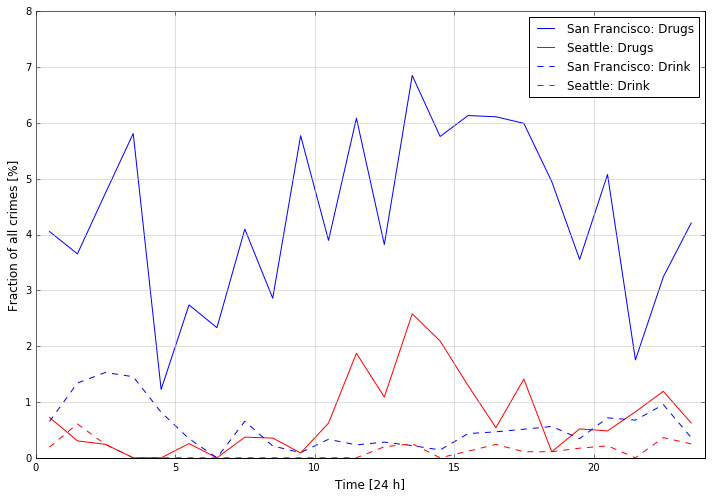

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(time_bin_centres, ratios["SF_Drugs"],      label="San Francisco: Drugs", c="b", linestyle="-")
plt.plot(time_bin_centres, ratios["Seattle_Drugs"], label="Seattle: Drugs",       c="r", linestyle="-")
plt.plot(time_bin_centres, ratios["SF_Drink"],      label="San Francisco: Drink", c="b", linestyle="--")
plt.plot(time_bin_centres, ratios["Seattle_Drink"], label="Seattle: Drink",       c="r", linestyle="--")
ax.set_xlim([0,24])
ax.set_ylim([0,8])
ax.set_xlabel("Time [24 h]",fontsize=12)
ax.set_ylabel("Fraction of all crimes [%]",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')
plt.legend()
plt.show()

This is the limited statistics version of the final figure displayed at the top of the page. The same conclusions can be drawn from this as that.